In [10]:
import requests, pandas as pd, time, re, nltk, matplotlib.pyplot as plt, seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [9]:
!pip install nltk wordcloud gensim sentence-transformers scikit-learn matplotlib pandas numpy bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 12.9 MB/s eta 0:00:00


 Data Capture

In [15]:
COMPANY = "NVIDIA"
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")
lemm = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
def fetch_reddit(query, limit=1000):
    url = "https://api.pullpush.io/reddit/search/submission/"
    posts = []
    params = {"q": query, "size": 100, "sort": "desc"}
    while len(posts) < limit:
        r = requests.get(url, params=params, timeout=10)
        if r.status_code != 200:
            break
        data = r.json().get("data", [])
        if not data:
            break
        for d in data:
            posts.append({
                "source": "reddit",
                "title": d.get("title", ""),
                "text": d.get("selftext", ""),
                "created_at": pd.to_datetime(d.get("created_utc"), unit="s", errors="coerce")
            })
        params["before"] = data[-1].get("created_utc")
        time.sleep(0.3)
    return pd.DataFrame(posts)

In [17]:
def fetch_hackernews(query, pages=10):
    url = "https://hn.algolia.com/api/v1/search"
    stories = []
    for p in range(pages):
        params = {"query": query, "tags": "story", "hitsPerPage": 100, "page": p}
        r = requests.get(url, params=params, timeout=10)
        if r.status_code != 200:
            break
        hits = r.json().get("hits", [])
        for h in hits:
            stories.append({
                "source": "hackernews",
                "title": h.get("title", ""),
                "text": h.get("story_text") or "",
                "created_at": pd.to_datetime(h.get("created_at"), errors="coerce")
            })
        time.sleep(0.3)
    return pd.DataFrame(stories)

In [18]:
reddit_df = fetch_reddit(COMPANY, limit=1000)
hn_df = fetch_hackernews(COMPANY, pages=10)
print(f"Fetched {len(reddit_df)} Reddit and {len(hn_df)} HackerNews posts")

Fetched 100 Reddit and 1000 HackerNews posts


Data Cleaning and Merging

In [19]:
merged = pd.concat([reddit_df, hn_df], ignore_index=True)
merged["text_all"] = merged["title"].fillna("") + " " + merged["text"].fillna("")
merged.drop_duplicates(subset=["text_all"], inplace=True)
merged.dropna(subset=["text_all"], inplace=True)
print(f"After cleaning, total posts: {len(merged)}")

After cleaning, total posts: 1084


In [20]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = [lemm.lemmatize(w) for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

merged["clean_text"] = merged["text_all"].apply(clean_text)

Word Cloud Visualization

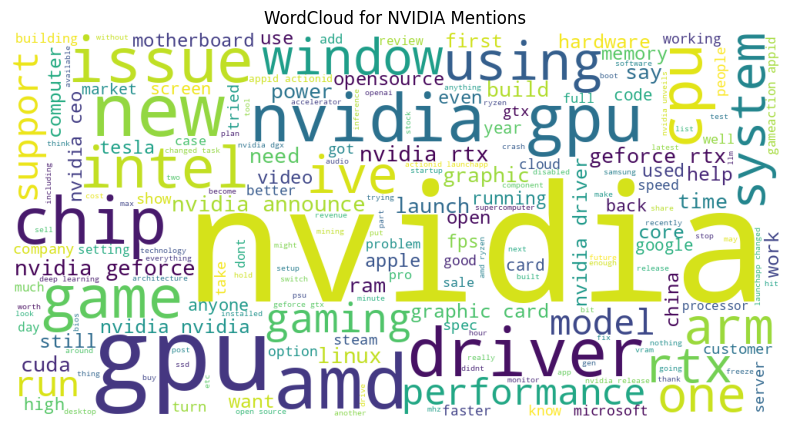

In [21]:
all_text = " ".join(merged["clean_text"])
plt.figure(figsize=(10,5))
plt.imshow(WordCloud(width=1000, height=500, background_color="white").generate(all_text))
plt.axis("off")
plt.title(f"WordCloud for {COMPANY} Mentions")
plt.show()

Sentiment Analysis

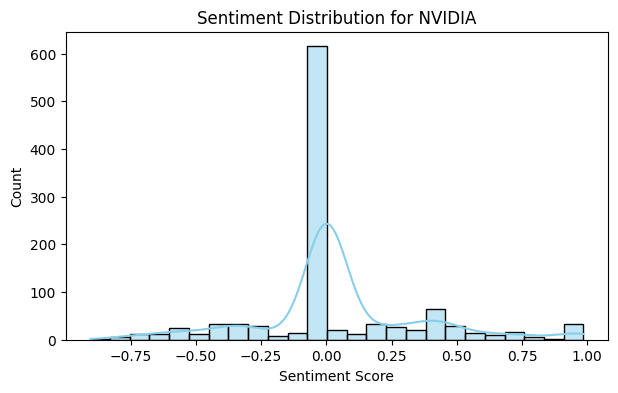

In [22]:
s_a = SentimentIntensityAnalyzer()
merged["sentiment"] = merged["clean_text"].apply(lambda x: s_a.polarity_scores(x)["compound"])

plt.figure(figsize=(7,4))
sns.histplot(merged["sentiment"], bins=25, kde=True, color="skyblue")
plt.title(f"Sentiment Distribution for {COMPANY}")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

In [23]:
summary = {
    "Total Posts": len(merged),
    "Average Sentiment": round(merged["sentiment"].mean(), 3),
    "Positive Posts": (merged["sentiment"] > 0.05).sum(),
    "Negative Posts": (merged["sentiment"] < -0.05).sum(),
    "Neutral Posts": ((merged["sentiment"] >= -0.05) & (merged["sentiment"] <= 0.05)).sum()
}
print("\n--- Sentiment Summary ---")
for k, v in summary.items():
    print(f"{k}: {v}")


--- Sentiment Summary ---
Total Posts: 1084
Average Sentiment: 0.049
Positive Posts: 284
Negative Posts: 184
Neutral Posts: 616


Transformer Embeddings and Topic Modeling

In [24]:
print("\nGenerating Sentence-BERT embeddings and running BERTopic...")
model = SentenceTransformer("all-MiniLM-L6-v2")
texts = merged["clean_text"].tolist()
embeddings = model.encode(texts, show_progress_bar=True)

topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(texts, embeddings)


Generating Sentence-BERT embeddings and running BERTopic...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [25]:
merged["topic"] = topics
topic_info = topic_model.get_topic_info()
print("\n--- Top Topics ---")
print(topic_info.head(10))


--- Top Topics ---
   Topic  Count                                  Name  \
0     -1    306            -1_nvidia_nvidias_gpu_gpus   
1      0     86       0_company_valuable_apple_nvidia   
2      1     83       1_rtx_geforce_nvidia_raytracing   
3      2     62         2_cuda_deep_learning_deepseek   
4      3     56      3_driver_linux_kernel_opensource   
5      4     50  4_nvidia_torvalds_celebrating_cringy   
6      5     46           5_stolen_hacker_nvidia_data   
7      6     46             6_china_chip_export_trump   
8      7     33          7_grace_hopper_cpu_superchip   
9      8     32     8_arm_takeover_softbanks_softbank   

                                      Representation  \
0  [nvidia, nvidias, gpu, gpus, open, pcie, tegra...   
1  [company, valuable, apple, nvidia, market, sto...   
2  [rtx, geforce, nvidia, raytracing, nvidias, se...   
3  [cuda, deep, learning, deepseek, nvidia, nix, ...   
4  [driver, linux, kernel, opensource, wayland, o...   
5  [nvidia, torv

In [26]:
topic_model.visualize_barchart(top_n_topics=8).show()
topic_model.visualize_heatmap().show()

The analyses show that NVIDIA discussions are largely centered on product performance, AI/GPU technology, and market value. Most mentions are factual or neutral, with a slightly positive overall sentiment. Positive topics focus on gaming and AI innovations, while negative discussions are driven by driver issues, technical friction, and corporate controversies. Together, these insights highlight both the strengths and challenges in public perception of NVIDIA.